# Introduction

**Goal**  
In this subproject, we test different approaches (TFIDF, bow, wword2vec) with different models (logistic regression, random forest classifier, lstm and bi directional lstm) in order to predict if the sentiment of a movie review is positive or negative.

**Method**
* Importing Data and Librairies
* Exploring the data
* Cleaning the data
* Convert text data into numerical representations with different approaches: TFIDF, BoW, Word2Vec
* Train different models with different vectors
* Compare

# Import Libraries and Data

In [ ]:
!pip install datasets --quiet
from datasets import load_dataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import re
from nltk.corpus import stopwords
from numpy import array
import nltk
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, GlobalMaxPooling1D, Conv1D, Flatten, Bidirectional, Dropout

In [ ]:
!pip install emoji --quiet
import emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 8.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re
import logging
import pandas as pd

import nltk.data
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, RegexpTokenizer

import gensim
from gensim.models import word2vec, KeyedVectors

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.tokenize import word_tokenize


In [ ]:
dataset = load_dataset("allocine")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/160000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['review', 'label'],
        num_rows: 160000
    })
    validation: Dataset({
        features: ['review', 'label'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['review', 'label'],
        num_rows: 20000
    })
})

In [ ]:
train_data = pd.DataFrame(dataset['train'])
validation_data = pd.DataFrame(dataset['validation'])
test_data = pd.DataFrame(dataset['test'])

# Data Exploration

We take a quick look at the data and at the classes, checking if they are balanced or not.

In [ ]:
display(train_data.head())
print(train_data.shape)

,review,label
0,Si vous cherchez du cinéma abrutissant à tous ...,0
1,"Trash, re-trash et re-re-trash...! Une horreur...",0
2,"Et si, dans les 5 premières minutes du film, l...",0
3,Mon dieu ! Quelle métaphore filée ! Je suis ab...,0
4,"Premier film de la saga Kozure Okami, ""Le Sabr...",1


(160000, 2)


label
1    80587
0    79413
Name: count, dtype: int64


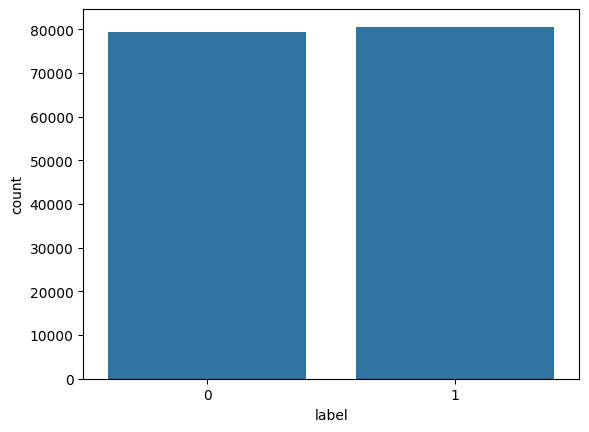

In [ ]:
sns.countplot(x=train_data['label'])
print(train_data["label"].value_counts())

This plot is showing us that we have balanced classes.

In [ ]:
# Checking for missing values
train_data.isnull().values.any()

False

In [ ]:
# Exemple de review
train_data['review'][99]

'Premièrement je souhaiterai demander à allo ciné de pouvoir mettre une note négative à ce film. Deuxièmement ... mais "Où " est passé l\'argent de l\'hypothèque de la maison de Vin Diesel. Troisièmement .. heureusement que je n\'ai pas payé ma place de cinéma sinon j\'aurai demandé à être remboursé. En conclusion :N\'allez pas voir ce film !!!'

# Data Cleaning

Pretreatment pipeline:
- verify non alphab characters and decide to kepp, modify or delete them
  - Emoji handling: replace by words
  - HTML tags and line breaks \n: replace by " "
  - ASCII and unicode: replace by " "
  - Other characters non alphab: replace by " "
- Stopwords: delete them all except for negation words

In [ ]:
# Extract all non-alphabetic characters and store them in a set
non_alphab_chars = np.unique([char for review in train_data['review'] for char in review if not char.isalpha()])
print(non_alphab_chars)

[' ' '!' '"' '#' '$' '%' '&' "'" '(' ')' '*' '+' ',' '-' '.' '/' '0' '1'
 '2' '3' '4' '5' '6' '7' '8' '9' ':' ';' '<' '=' '>' '?' '@' '[' '\\' ']'
 '^' '_' '`' '{' '|' '}' '~' '\x80' '\x8c' '\x91' '\x93' '\x94' '\x96'
 '\x97' '\x9c' '¡' '£' '¤' '¥' '¦' '§' '¨' '©' '«' '¬' '\xad' '®' '¯' '°'
 '±' '²' '³' '´' '·' '»' '½' '¾' '¿' '×' '̀' '́' '̈' '̧' '͜' '͡' '\u200b'
 '\u200d' '\u200e' '–' '—' '‘' '’' '‚' '“' '”' '•' '…' '\u202a' '\u202c'
 '′' '″' '‼' '€' '→' '∅' '∙' '►' '◄' '★' '☆' '☹' '☺' '♀' '♂' '♡' '♥' '♫'
 '⚠' '⚫' '✊' '✌' '✔' '❗' '❣' '❤' '➖' '⭐' '《' '》' '【' '】' '\ue045' '\ue046'
 '\uf04c' '\uf0ab' '\uf0e0' '\uf8ff' '️' '\ufeff' '�' '🇬' '🇮' '🇳' '🇷' '🌙'
 '🌟' '🌱' '🌳' '🌵' '🍀' '🍿' '🎀' '🎈' '🎞' '🎥' '🎧' '🎬' '🎶' '🏄' '🏻' '🏼' '🏽' '🏾'
 '👀' '👊' '👌' '👍' '👎' '👏' '👑' '👦' '👱' '👶' '👸' '💋' '💎' '💓' '💕' '💖' '💗' '💙'
 '💚' '💛' '💜' '💝' '💣' '💩' '💪' '💯' '📽' '🔥' '🔫' '🔴' '🔵' '🗡' '😀' '😁' '😂' '😃'
 '😄' '😅' '😆' '😇' '😈' '😉' '😊' '😋' '😍' '😎' '😏' '😑' '😒' '😔' '😕' '😖' '😗' '😘'
 '😚' '😜' '😟' '😠' '😡' '😢' '😤' '😥' '😧' '😨' '😩' '😪

## Emojis handling

Replace emojis by text. For example 😁 becomes "visage souriant aux yeux rieurs"

In [ ]:
def replace_emoji_by_text(review):

  updated_review = emoji.demojize(review, delimiters=("", ""), language="fr")

  return updated_review

## HTML Tags and line break handling

Replace by empty space.

In [ ]:
def split_text(review):
  # Remove HTML tags using regular expression
  review = re.sub(r'<[^>]+>', '', review)

  # split by \n
  lines = review.split('\n')
  return lines

## Other non alphabetic characters

I decided to delete all the other non alphabetic characters, so i delete unnecessary symbols and keep the text simple.  
Keeping them would have affect the result if we are depending of the frequency of words or characters.





In [ ]:
def remove_punctuation(review):
    # Constructing regex pattern to match any of the characters in non_alphab_chars
    pattern = '|'.join(map(re.escape, non_alphab_chars))

    # Remove punctuation from each line
    cleaned_lines = [re.sub(pattern, ' ', rev) for rev in review]

    # Join the cleaned lines back into a single string
    cleaned_review = ' '.join(cleaned_lines)

    return cleaned_review

## Stopwords handling

I decided to delete the stopwords defined by nltl for the french language, except for negation words like "n", "ne", and "pas" which are useful to determine sentiments.  
In this way, I am reducing vocabulary and we have less noise, but we keep important information for the sentiment detection.

In [ ]:
french_stopwords = set(stopwords.words('french'))

# Enlever négacions du set
french_stopwords.remove('n')
french_stopwords.remove('ne')
french_stopwords.remove('pas')


In [ ]:
def remove_stopwords(review):
    # Tokenize the review
    tokens = nltk.word_tokenize(review)

    # Remove stopwords
    filtered_tokens = [word for word in tokens if word.lower() not in french_stopwords]

    # Join the filtered tokens back into a single string
    filtered_review = ' '.join(filtered_tokens)

    return filtered_review

## Data Cleaning preprocessing function: preprocess_text(X)

In this step we put all the preprocessing step together in one function for better usability

In [ ]:
def preprocess_text(X):
  ''' Preprocessionne le texte: On applique sur les reviews du paramètres X le remplacement des emoji par du texte, la suppression des tags html et des retour a la ligne, la suppression des charactères non alphabétique et la suppression des stopwords '''
  res = X.copy()

  res['cleaned_review'] = res['review'].apply(replace_emoji_by_text)
  res['cleaned_review'] = res['cleaned_review'].apply(split_text)
  res['cleaned_review'] = res['cleaned_review'].apply(remove_punctuation)
  res['cleaned_review'] = res['cleaned_review'].apply(remove_stopwords)
  res['cleaned_review'] = res['cleaned_review'].str.lower()

  return res

In [ ]:
train_data = preprocess_text(train_data)

In [ ]:
# Example
train_data['cleaned_review'][99]

'premièrement souhaiterai demander allo ciné pouvoir mettre note négative film deuxièmement où passé argent hypothèque maison vin diesel troisièmement heureusement n pas payé place cinéma sinon demandé être remboursé conclusion n allez pas voir film'

# Baseline model

Both bag-of-words (BoW) and TF-IDF (Term Frequency-Inverse Document Frequency) are techniques used to convert text data into numerical representations suitable for machine learning algorithms.
  
  
We create the representation only on train data.

## Bag of words

The bag of words creates a vector where each dimension corresponds to a unique word and the value of the dimension represents the frequency of that word


In [ ]:
def tokenizing(text):
  '''
  In this function, the review gets tokenized into a list of words.
  We also filter out non alphabetic tokens,
  and then we join the filtered list of words back into a single string separated by spaces
  as CountVectorizer expects input in the form of strings
  '''
  return " ".join([w for w in word_tokenize(text) if w.isalpha()])


In [ ]:
def bag_of_words_vectorize(X, column_name):
  '''
  Vectorize the text data using CountVectorizer
  '''
  res = X.copy()

  count_vec = CountVectorizer()

  res_vec = count_vec.fit_transform(res[column_name])

  return res_vec, count_vec.vocabulary_, count_vec

In [ ]:
train_data['cleaned_reviews_tokenized'] = train_data['cleaned_review'].apply(tokenizing)

train_data_bow_vec, bow_vocab, count_vectorizer = bag_of_words_vectorize(train_data, "cleaned_reviews_tokenized")

# train_data_vec is now the bag-of-words representation of the data, bow_vocab holds the vocabulary

In [ ]:
train_data_bow_vec

<160000x150045 sparse matrix of type '<class 'numpy.int64'>'
	with 7721920 stored elements in Compressed Sparse Row format>

### Vocabulary

In [ ]:
bow_vocab

{'si': 124717,
 'cherchez': 23310,
 'cinéma': 24663,
 'abrutissant': 524,
 'tous': 136037,
 'étages': 149098,
 'aucune': 9744,
 'peur': 100905,
 'cliché': 25302,
 'castagnettes': 21310,
 'moralement': 88876,
 'douteux': 38349,
 'from': 56670,
 'paris': 98258,
 'with': 144322,
 'love': 80899,
 'fait': 51989,
 'toutes': 136053,
 'productions': 105696,
 'besson': 13869,
 'via': 141174,
 'filière': 53731,
 'europacorp': 50025,
 'quoi': 109607,
 'faire': 51946,
 'naître': 92236,
 'moquerie': 88850,
 'encore': 46791,
 'fois': 54975,
 'montrée': 88739,
 'comme': 26637,
 'capitale': 20392,
 'exotique': 50894,
 'attention': 9473,
 'dirige': 36588,
 'vers': 141014,
 'banlieue': 12005,
 'trouve': 137771,
 'tout': 136046,
 'plein': 102609,
 'intégristes': 72026,
 'musulmans': 90177,
 'prêts': 107582,
 'sauter': 121790,
 'caisson': 19581,
 'ambassadrice': 4489,
 'américaine': 5107,
 'nauséeux': 92086,
 'alors': 4173,
 'dit': 37220,
 'va': 139823,
 'moins': 88082,
 'pouvoir': 104648,
 'apprécier': 7

## TF-IDF

TF-IDF (Term Frequency-Inverse Document Frequency):

Like BoW, it represents each document as a vector. But, it considers both the term frequency and the inverse document frequency.  
  
The term frequency measures the frequency of a term (like BoW)  
  
The inverse document frequency assigns higher weights to words that a rare across the entire corpus and lower weights to terms that are common.
  
The TF IDF value is TF * IDF


In [ ]:
# using the same tokenizing function so we can use train_data['cleaned_reviews_tokenized']

In [ ]:
def tfidf_vectorize(X, column_name):
  '''
  Vectorize the text data using TfidfVectorizer
  '''
  res = X.copy()

  tfidf_vec = TfidfVectorizer()

  res_vec = tfidf_vec.fit_transform(res[column_name])

  return res_vec, tfidf_vec.vocabulary_, tfidf_vec

In [ ]:
train_data_tfidf_vec, tfidf_vocab, tfidf_vectorizer = tfidf_vectorize(train_data, "cleaned_reviews_tokenized")


In [ ]:
train_data_tfidf_vec

<160000x150045 sparse matrix of type '<class 'numpy.float64'>'
	with 7721920 stored elements in Compressed Sparse Row format>

### Vocabulary

In [ ]:
tfidf_vocab

{'si': 124717,
 'cherchez': 23310,
 'cinéma': 24663,
 'abrutissant': 524,
 'tous': 136037,
 'étages': 149098,
 'aucune': 9744,
 'peur': 100905,
 'cliché': 25302,
 'castagnettes': 21310,
 'moralement': 88876,
 'douteux': 38349,
 'from': 56670,
 'paris': 98258,
 'with': 144322,
 'love': 80899,
 'fait': 51989,
 'toutes': 136053,
 'productions': 105696,
 'besson': 13869,
 'via': 141174,
 'filière': 53731,
 'europacorp': 50025,
 'quoi': 109607,
 'faire': 51946,
 'naître': 92236,
 'moquerie': 88850,
 'encore': 46791,
 'fois': 54975,
 'montrée': 88739,
 'comme': 26637,
 'capitale': 20392,
 'exotique': 50894,
 'attention': 9473,
 'dirige': 36588,
 'vers': 141014,
 'banlieue': 12005,
 'trouve': 137771,
 'tout': 136046,
 'plein': 102609,
 'intégristes': 72026,
 'musulmans': 90177,
 'prêts': 107582,
 'sauter': 121790,
 'caisson': 19581,
 'ambassadrice': 4489,
 'américaine': 5107,
 'nauséeux': 92086,
 'alors': 4173,
 'dit': 37220,
 'va': 139823,
 'moins': 88082,
 'pouvoir': 104648,
 'apprécier': 7

## Preprocessing


#### Reloading data to start fresh

In [ ]:
train_data = pd.DataFrame(dataset['train'])
validation_data = pd.DataFrame(dataset['validation'])
test_data = pd.DataFrame(dataset['test'])

In [ ]:
train_data = preprocess_text(train_data)
validation_data = preprocess_text(validation_data)
test_data = preprocess_text(test_data)

In [ ]:
train_data.dtypes

review            object
label              int64
cleaned_review    object
dtype: object

#### Separating into X and y and removing review column

In [ ]:
def split_X_y(df, target_column_name, column_names_to_drop):
  res = df.copy()

  column_names_to_drop.append(target_column_name)
  X = res.drop(columns=column_names_to_drop)

  y = res[target_column_name]

  return X, y

In [ ]:
X_train, y_train = split_X_y(train_data, "label", ["review"])
X_test, y_test = split_X_y(test_data, "label", ["review"])
X_validation, y_validation = split_X_y(validation_data, "label", ["review"])

In [ ]:
X_train.head()

,cleaned_review
0,si cherchez cinéma abrutissant tous étages n a...
1,trash re trash re re trash horreur sans nom im...
2,si premières minutes film pathétique maquette ...
3,dieu quelle métaphore filée abasourdi réelleme...
4,premier film saga kozure okami sabre vengeance...


In [ ]:
y_train.head()

0    0
1    0
2    0
3    0
4    1
Name: label, dtype: int64

#### Tokenizing

In [ ]:
X_train['cleaned_review'] = X_train['cleaned_review'].apply(tokenizing)
X_test['cleaned_review'] = X_test['cleaned_review'].apply(tokenizing)
X_validation['cleaned_review'] = X_validation['cleaned_review'].apply(tokenizing)

#### Vectorizing BoW and TFIDF

##### BOW

In [ ]:
X_train_bow_vec, bow_vocab, bow_vectorizer = bag_of_words_vectorize(train_data, "cleaned_review")


In [ ]:
X_test_bow_vec = bow_vectorizer.transform(X_test['cleaned_review'])
X_validation_bow_vec = bow_vectorizer.transform(X_validation['cleaned_review'])

##### TFIDF

In [ ]:
X_train_tfidf_vec, tfidf_vocab, tfidf_vectorizer = tfidf_vectorize(train_data, "cleaned_review")


In [ ]:
X_test_tfidf_vec = tfidf_vectorizer.transform(X_test['cleaned_review'])
X_validation_tfidf_vec = tfidf_vectorizer.transform(X_validation['cleaned_review'])

## Logistic Regression

In [ ]:
all_results = []

### BoW

In [ ]:
scaler = MaxAbsScaler()
X_train_bow_vec_scaled = scaler.fit_transform(X_train_bow_vec )
X_validation_bow_vec_scaled = scaler.transform(X_validation_bow_vec)
X_test_bow_vec_scaled = scaler.transform(X_test_bow_vec)

In [ ]:
lr_bow = LogisticRegression(max_iter=500, random_state=42)
lr_bow.fit(X_train_bow_vec_scaled, y_train)

LogisticRegression(max_iter=500, random_state=42)

In [ ]:
y_lr_bow_pred_validation = lr_bow.predict(X_validation_bow_vec_scaled)

print(classification_report(y_validation, y_lr_bow_pred_validation))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     10204
           1       0.92      0.93      0.92      9796

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000



In [ ]:
y_lr_bow_pred_test = lr_bow.predict(X_test_bow_vec_scaled)

print(classification_report(y_test, y_lr_bow_pred_test))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     10408
           1       0.92      0.92      0.92      9592

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000



In [ ]:
# Concatenate predictions and true labels from both validation and test sets
y_combined_true = np.concatenate((y_validation, y_test))
y_combined_pred = np.concatenate((y_lr_bow_pred_validation, y_lr_bow_pred_test))

# Combined classification report
classification_report_combined = classification_report(y_combined_true, y_combined_pred)
print("Joint Classification Report:")
print(classification_report_combined)

Joint Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93     20612
           1       0.92      0.93      0.92     19388

    accuracy                           0.92     40000
   macro avg       0.92      0.92      0.92     40000
weighted avg       0.92      0.92      0.92     40000



In [ ]:
# Compute other metrics
accuracy_combined = accuracy_score(y_combined_true, y_combined_pred)
precision_combined = precision_score(y_combined_true, y_combined_pred, average='weighted')
recall_combined = recall_score(y_combined_true, y_combined_pred, average='weighted')
f1_combined = f1_score(y_combined_true, y_combined_pred, average='weighted')

all_results.append({'model_name': 'lr_bow',
                    'classification_report': classification_report_combined,
                    'accuracy': accuracy_combined,
                    'precision' :precision_combined,
                    'recall': recall_combined,
                    'f1_score': f1_combined})


### TFIDF

In [ ]:
scaler = MaxAbsScaler()
X_train_tfidf_vec_scaled = scaler.fit_transform(X_train_tfidf_vec )
X_validation_tfidf_vec_scaled = scaler.transform(X_validation_tfidf_vec)
X_test_tfidf_vec_scaled = scaler.transform(X_test_tfidf_vec)

In [ ]:
lr_tfidf = LogisticRegression(max_iter=500, random_state=42)
lr_tfidf.fit(X_train_tfidf_vec_scaled, y_train)

LogisticRegression(max_iter=500, random_state=42)

In [ ]:
y_lr_tfidf_pred_validation = lr_tfidf.predict(X_validation_tfidf_vec_scaled)

print(classification_report(y_validation, y_lr_tfidf_pred_validation))

y_lr_tfidf_pred_test = lr_tfidf.predict(X_test_tfidf_vec_scaled)

print(classification_report(y_test, y_lr_tfidf_pred_test))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     10204
           1       0.92      0.93      0.92      9796

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     10408
           1       0.92      0.92      0.92      9592

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000



In [ ]:
# Concatenate predictions and true labels from both validation and test sets
y_combined_true = np.concatenate((y_validation, y_test))
y_combined_pred = np.concatenate((y_lr_tfidf_pred_validation, y_lr_tfidf_pred_test))

# Combined classification report
classification_report_combined = classification_report(y_combined_true, y_combined_pred)
print("Joint Classification Report:")
print(classification_report_combined)

# Compute other metrics
accuracy_combined = accuracy_score(y_combined_true, y_combined_pred)
precision_combined = precision_score(y_combined_true, y_combined_pred, average='weighted')
recall_combined = recall_score(y_combined_true, y_combined_pred, average='weighted')
f1_combined = f1_score(y_combined_true, y_combined_pred, average='weighted')

all_results.append({'model_name': 'lr_tfidf',
                    'classification_report': classification_report_combined,
                    'accuracy': accuracy_combined,
                    'precision' :precision_combined,
                    'recall': recall_combined,
                    'f1_score': f1_combined})


Joint Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93     20612
           1       0.92      0.93      0.92     19388

    accuracy                           0.92     40000
   macro avg       0.92      0.92      0.92     40000
weighted avg       0.92      0.92      0.92     40000



## Random Forest Classifier

### BoW

In [ ]:
import multiprocessing

In [ ]:
n_cpus = multiprocessing.cpu_count()
n_cpus

12

In [ ]:
# Instance of RFC
random_forest = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=n_cpus)

# Train the Random Forest classifier using the bag-of-words representation
random_forest.fit(X_train_bow_vec_scaled, y_train)

# Make predictions on the validation set
y_rf_bow_pred_validation = random_forest.predict(X_validation_bow_vec_scaled)


# Print classification report for validation set
print("Classification Report for Validation Set (Random Forest with BoW):")
print(classification_report(y_validation, y_rf_bow_pred_validation))

# Make predictions on the test set
y_rf_bow_pred_test = random_forest.predict(X_test_bow_vec_scaled)

# Print classification report for test set
print("Classification Report for Test Set (Random Forest with BoW):")
print(classification_report(y_test, y_rf_bow_pred_test))

# Concatenate predictions and true labels from both validation and test sets
y_combined_true = np.concatenate((y_validation, y_test))
y_combined_pred = np.concatenate((y_rf_bow_pred_validation, y_rf_bow_pred_test))

# Combined classification report
classification_report_combined = classification_report(y_combined_true, y_combined_pred)
print("Joint Classification Report:")
print(classification_report_combined)

# Compute other metrics
accuracy_combined = accuracy_score(y_combined_true, y_combined_pred)
precision_combined = precision_score(y_combined_true, y_combined_pred, average='weighted')
recall_combined = recall_score(y_combined_true, y_combined_pred, average='weighted')
f1_combined = f1_score(y_combined_true, y_combined_pred, average='weighted')

all_results.append({'model_name': 'rf_bow',
                    'classification_report': classification_report_combined,
                    'accuracy': accuracy_combined,
                    'precision' :precision_combined,
                    'recall': recall_combined,
                    'f1_score': f1_combined})



Classification Report for Validation Set (Random Forest with BoW):
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     10204
           1       0.90      0.89      0.90      9796

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000

Classification Report for Test Set (Random Forest with BoW):
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     10408
           1       0.90      0.88      0.89      9592

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000

Joint Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     20612
           1       0.90      0.88      0.89     19388

    accuracy             

### tfidf

In [ ]:
# Instance of RFC
random_forest = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=n_cpus)

# Train the Random Forest classifier using the bag-of-words representation
random_forest.fit(X_train_tfidf_vec_scaled, y_train)

# Make predictions on the validation set
y_rf_tfidf_pred_validation = random_forest.predict(X_validation_tfidf_vec_scaled)

# Print classification report for validation set
print("Classification Report for Validation Set (Random Forest with tfidf):")
print(classification_report(y_validation, y_rf_tfidf_pred_validation))

# Make predictions on the test set
y_rf_tfidf_pred_test = random_forest.predict(X_test_tfidf_vec_scaled)

# Print classification report for test set
print("Classification Report for Test Set (Random Forest with tfidf):")
print(classification_report(y_test, y_rf_tfidf_pred_test))

# Concatenate predictions and true labels from both validation and test sets
y_combined_true = np.concatenate((y_validation, y_test))
y_combined_pred = np.concatenate((y_rf_tfidf_pred_validation, y_rf_tfidf_pred_test))

# Combined classification report
classification_report_combined = classification_report(y_combined_true, y_combined_pred)
print("Joint Classification Report:")
print(classification_report_combined)

# Compute other metrics
accuracy_combined = accuracy_score(y_combined_true, y_combined_pred)
precision_combined = precision_score(y_combined_true, y_combined_pred, average='weighted')
recall_combined = recall_score(y_combined_true, y_combined_pred, average='weighted')
f1_combined = f1_score(y_combined_true, y_combined_pred, average='weighted')

all_results.append({'model_name': 'rf_tfidf',
                    'classification_report': classification_report_combined,
                    'accuracy': accuracy_combined,
                    'precision' :precision_combined,
                    'recall': recall_combined,
                    'f1_score': f1_combined})



Classification Report for Validation Set (Random Forest with tfidf):
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     10204
           1       0.90      0.89      0.89      9796

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000

Classification Report for Test Set (Random Forest with tfidf):
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     10408
           1       0.90      0.88      0.89      9592

    accuracy                           0.89     20000
   macro avg       0.89      0.89      0.89     20000
weighted avg       0.89      0.89      0.89     20000

Joint Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     20612
           1       0.90      0.88      0.89     19388

    accuracy         

# word2vec
https://colab.research.google.com/drive/1RfPKYlZtprhTa01JjbWdxn0zrc6BkWII#scrollTo=ZNHMtmbqX-rl


https://colab.research.google.com/drive/1ycDht533QHER0ojrwPBR802W_hFAm6TV

Use existing pre-trained model from JP Fauconnier in French



```
@misc{fauconnier_2015,
	author = {Fauconnier, Jean-Philippe},
	title = {French Word Embeddings},
	url = {http://fauconnier.github.io},
	year = {2015}}
```



In [ ]:
path_word2vec_french = '/content/drive/MyDrive/BIHAR_FINAL_PROJECT/2_TEXT_PREDICTIONS/frWac_non_lem_no_postag_no_phrase_500_skip_cut200.bin'

model_fr = KeyedVectors.load_word2vec_format(path_word2vec_french, binary=True, unicode_errors="ignore")

In [ ]:
print(model_fr.most_similar("terrible"))
print(model_fr.similarity('horrible', 'terrible'))

[('horrible', 0.7367780208587646), ('épouvantable', 0.6798000931739807), ('atroce', 0.6786210536956787), ('affreuse', 0.672873318195343), ('terrifiant', 0.6677480936050415), ('terrifiante', 0.6496243476867676), ('effroyable', 0.647688090801239), ('cruelle', 0.6467640995979309), ('terribles', 0.6454005837440491), ('désespoir', 0.6354192495346069)]
0.7367779


In [ ]:
X_train['cleaned_review_word2vec'] = X_train['cleaned_review'].apply(lambda x: tokenizing(x).split())
X_test['cleaned_review_word2vec'] = X_test['cleaned_review'].apply(lambda x: tokenizing(x).split())
X_validation['cleaned_review_word2vec'] = X_validation['cleaned_review'].apply(lambda x: tokenizing(x).split())

In [ ]:

embedding_dim = model_fr.vector_size
print("Dimensionality of word embeddings:", embedding_dim) # should be 500


Dimensionality of word embeddings: 500


In [ ]:
def calculate_resulting_vector(tokens, model, embedding_dim): # i shouldnt have numeric values
    resulting_vector = np.zeros(embedding_dim)
    for token in tokens:
        if token in model.key_to_index:
            resulting_vector += model[token]
    return resulting_vector


In [ ]:
def vectors_matrix(texts, model, embedding_dim):
    x = len(texts)
    y = embedding_dim # dimension of model
    matrix = np.zeros((x, y))
    for i in range(x):
        tokens = texts.iloc[i]
        resulting_vector = calculate_resulting_vector(tokens, model, embedding_dim)
        matrix[i] = resulting_vector
    return matrix

In [ ]:

X_train_matrix = vectors_matrix(X_train['cleaned_review_word2vec'], model_fr, embedding_dim)
X_test_matrix = vectors_matrix(X_test['cleaned_review_word2vec'], model_fr, embedding_dim)
X_validation_matrix = vectors_matrix(X_validation['cleaned_review_word2vec'], model_fr, embedding_dim)

In [ ]:
X_train_matrix

array([[-1.34699361, -2.54386747, -1.41322073, ..., -7.56941275,
         2.92947856,  5.98181022],
       [-2.81814076, -2.42564102, -5.75765793, ..., -4.88026688,
         3.55653168,  6.80679026],
       [-1.64752068, -1.79186394, -2.53612857, ..., -2.32910629,
         1.94440179,  2.08383102],
       ...,
       [-2.54091059, -1.70864813, -2.23633562, ..., -5.41020271,
         3.30982656,  2.03328578],
       [ 0.07775052, -0.12933394,  0.36608832, ..., -0.70084252,
         0.25657771,  0.65640018],
       [-0.94205726, -1.59122348, -1.01093023, ..., -1.39784084,
         0.2791167 ,  1.43178073]])

## Linear Regression + Word2vec

In [ ]:
scaler = MaxAbsScaler()
X_train_word2vec_vec_scaled = scaler.fit_transform(X_train_matrix )
X_validation_word2vec_vec_scaled = scaler.transform(X_validation_matrix)
X_test_word2vec_vec_scaled = scaler.transform(X_test_matrix)

In [ ]:

lr_word2vec = LogisticRegression(max_iter=500, random_state=42)
lr_word2vec.fit(X_train_word2vec_vec_scaled, y_train)

y_lr_word2vec_pred_validation = lr_word2vec.predict(X_validation_word2vec_vec_scaled)

print(classification_report(y_validation, y_lr_word2vec_pred_validation))

y_lr_word2vec_pred_test = lr_word2vec.predict(X_test_word2vec_vec_scaled)

print(classification_report(y_test, y_lr_word2vec_pred_test))

# Concatenate predictions and true labels from both validation and test sets
y_combined_true = np.concatenate((y_validation, y_test))
y_combined_pred = np.concatenate((y_lr_word2vec_pred_validation, y_lr_word2vec_pred_test))

# Combined classification report
classification_report_combined = classification_report(y_combined_true, y_combined_pred)
print("Joint Classification Report:")
print(classification_report_combined)

# Compute other metrics
accuracy_combined = accuracy_score(y_combined_true, y_combined_pred)
precision_combined = precision_score(y_combined_true, y_combined_pred, average='weighted')
recall_combined = recall_score(y_combined_true, y_combined_pred, average='weighted')
f1_combined = f1_score(y_combined_true, y_combined_pred, average='weighted')

all_results.append({'model_name': 'lr_word2vec',
                    'classification_report': classification_report_combined,
                    'accuracy': accuracy_combined,
                    'precision' :precision_combined,
                    'recall': recall_combined,
                    'f1_score': f1_combined})


              precision    recall  f1-score   support

           0       0.88      0.88      0.88     10204
           1       0.88      0.87      0.87      9796

    accuracy                           0.88     20000
   macro avg       0.88      0.88      0.88     20000
weighted avg       0.88      0.88      0.88     20000

              precision    recall  f1-score   support

           0       0.88      0.89      0.88     10408
           1       0.88      0.86      0.87      9592

    accuracy                           0.88     20000
   macro avg       0.88      0.88      0.88     20000
weighted avg       0.88      0.88      0.88     20000

Joint Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.88     20612
           1       0.88      0.87      0.87     19388

    accuracy                           0.88     40000
   macro avg       0.88      0.88      0.88     40000
weighted avg       0.88      0.88      0.88  

In [ ]:
results_df = pd.DataFrame({
    'Review Text': X_test['cleaned_review'],
    'True Label': y_test,
    'Predicted Label': y_lr_word2vec_pred_test
})

pd.set_option('display.max_colwidth', None)  # Set column width to display entire contents

results_df.head()

,Review Text,True Label,Predicted Label
0,magnifique épopée belle histoire touchante acteurs interprètent très bien rôles mel gibson heath ledger jason isaacs genre film savoure famille,1,1
1,n pas aimé pourtant mets étoiles car expérience louable rien conventionnel ici visite e jonchée idées originales soucis tout ceci vraiment place film f tirant horreur voici film inverse tant autres droit mériterait peut être remake,0,0
2,dessin animé brille féerie chansons,1,0
3,si là renouveau cinéma français tout foutrement chiant si objet très stylisé tension palpable film paraît plutôt creux,0,0
4,pourtant doutait second volet très mauvais sans fraîcheur particulièrement lourdingue quel dommage,0,0


## Random Forest Classifier + Word2vec

In [ ]:
rf_word2vec = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=n_cpus)

rf_word2vec.fit(X_train_word2vec_vec_scaled, y_train)

y_rf_word2vec_pred_validation = rf_word2vec.predict(X_validation_word2vec_vec_scaled)

print(classification_report(y_validation, y_rf_word2vec_pred_validation))

y_rf_word2vec_pred_test = rf_word2vec.predict(X_test_word2vec_vec_scaled)

print(classification_report(y_test, y_rf_word2vec_pred_test))

# Concatenate predictions and true labels from both validation and test sets
y_combined_true = np.concatenate((y_validation, y_test))
y_combined_pred = np.concatenate((y_rf_word2vec_pred_validation, y_rf_word2vec_pred_test))

# Combined classification report
classification_report_combined = classification_report(y_combined_true, y_combined_pred)
print("Joint Classification Report:")
print(classification_report_combined)

# Compute other metrics
accuracy_combined = accuracy_score(y_combined_true, y_combined_pred)
precision_combined = precision_score(y_combined_true, y_combined_pred, average='weighted')
recall_combined = recall_score(y_combined_true, y_combined_pred, average='weighted')
f1_combined = f1_score(y_combined_true, y_combined_pred, average='weighted')

all_results.append({'model_name': 'rf_word2vec',
                    'classification_report': classification_report_combined,
                    'accuracy': accuracy_combined,
                    'precision' :precision_combined,
                    'recall': recall_combined,
                    'f1_score': f1_combined})


              precision    recall  f1-score   support

           0       0.81      0.82      0.82     10204
           1       0.81      0.80      0.81      9796

    accuracy                           0.81     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.81      0.81      0.81     20000

              precision    recall  f1-score   support

           0       0.82      0.82      0.82     10408
           1       0.80      0.81      0.80      9592

    accuracy                           0.81     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.81      0.81      0.81     20000

Joint Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82     20612
           1       0.81      0.80      0.81     19388

    accuracy                           0.81     40000
   macro avg       0.81      0.81      0.81     40000
weighted avg       0.81      0.81      0.81  

In [ ]:
all_results

[{'model_name': 'lr_bow',
  'classification_report': '              precision    recall  f1-score   support\n\n           0       0.93      0.92      0.93     20612\n           1       0.92      0.93      0.92     19388\n\n    accuracy                           0.92     40000\n   macro avg       0.92      0.92      0.92     40000\nweighted avg       0.92      0.92      0.92     40000\n',
  'accuracy': 0.924875,
  'precision': 0.9249326437737665,
  'recall': 0.924875,
  'f1_score': 0.9248840311882701},
 {'model_name': 'lr_tfidf',
  'classification_report': '              precision    recall  f1-score   support\n\n           0       0.93      0.92      0.93     20612\n           1       0.92      0.93      0.92     19388\n\n    accuracy                           0.92     40000\n   macro avg       0.92      0.92      0.92     40000\nweighted avg       0.92      0.92      0.92     40000\n',
  'accuracy': 0.924625,
  'precision': 0.924698894448888,
  'recall': 0.924625,
  'f1_score': 0.9246

# LSTM

In this part i am creating multiple LSTM models and testing them.  

I am testing bidirectionality as well as different dropout rates and optimizers.  

I decided to not test batch normalization as I already have a big amount of models and in the previous image classification the batch_normalization didn't have an impact on the score.  

Also in the previous task I tested dropout rates up to 75% which I won't do in this case.   

I will fit the models on the different vectors (bow, tfidf and word2vec) to compare results.  






In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout, BatchNormalization
from keras import Input, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam, Adadelta, RMSprop
from keras.models import load_model
import pickle
import os
import keras

In [ ]:
# path to saved models
save_dir = '/content/drive/MyDrive/BIHAR_FINAL_PROJECT/2_TEXT_PREDICTIONS/MODELS'

# Initialize an empty dictionary to store models and their training results
model_results = {}

In [ ]:
# Save the all_results object
all_results_save_path = f"{save_dir}/all_results.pkl"
with open(all_results_save_path, 'wb') as file:
    pickle.dump(all_results, file)

In [ ]:
# Load the all_results object
all_results_save_path = f"{save_dir}/all_results.pkl"
with open(all_results_save_path, 'rb') as file:
    all_results = pickle.load(file)


In [ ]:
max_features = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review

In [ ]:
def create_lstm_model(optimizer, dropout=0, bidirectional=False):
  # Input for variable-length sequences of integers
  inputs = Input(shape=(None,), dtype="int32")

  # Embed each integer in a 128-dimensional vector
  x = Embedding(max_features, 128)(inputs)

  if bidirectional:
    # Add 2 bidirectional LSTMs
    x = Bidirectional(LSTM(64, return_sequences=True))(x)

    if dropout != 0:
      x = Dropout(dropout)(x)

    # second bidirectional LSTM
    x = Bidirectional(LSTM(64))(x)

    if dropout != 0:
      x = Dropout(dropout)(x)

  else:
    # First LSTM layer
    x = LSTM(64, return_sequences=True)(x)

    if dropout != 0:
      x = Dropout(dropout)(x)

    # second LSTM layer
    x = LSTM(64)(x)

    if dropout != 0:
      x = Dropout(dropout)(x)

  # Add a classifier
  outputs = Dense(1, activation="sigmoid")(x)
  model = Model(inputs, outputs)

  return model

In [ ]:
num_epochs = 15

In [ ]:
es = EarlyStopping(monitor="val_loss", patience=4)

In [ ]:
# https://www.researchgate.net/figure/Results-of-five-optimizers-applied-to-Bi-LSTM-CRF_tbl3_344375190
# Using their top 3

optimizers=['Adam', 'Adadelta', 'RMSprop']
dropout_rates=[0, 0.25, 0.5]
bidirectional_bool=[True, False]


training_vectors = [
    {"name": "word2vec", "vector_train":X_train_word2vec_vec_scaled, "vector_test": X_test_word2vec_vec_scaled , "vector_validation": X_validation_word2vec_vec_scaled}
                  ]

In [ ]:
models= []

In [ ]:
for dropout_rate in dropout_rates:
  for optimizer_name in optimizers:
    for bidirectional in bidirectional_bool:
      for training_vector in training_vectors:
        optimizer = getattr(keras.optimizers, optimizer_name)()

        model = create_lstm_model(optimizer=optimizer, dropout=dropout_rate, bidirectional=bidirectional)

        model.train_vector = training_vector['vector_train']
        model.test_vector = training_vector['vector_test']
        model.validation_vector = training_vector['vector_validation']

        model.vector_name = training_vector['name']
        model_name = f'Model_Bi_{bidirectional}_Dropout_{dropout_rate}_BN_False_Optimizer_{optimizer_name}_VEC_{model.vector_name}'
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=["accuracy"])
        model.model_name = model_name
        models.append(model)

In [ ]:
len(models)

18

In [ ]:
## Verifying if the models exist.
results_save_path = f"{save_dir}/results.pkl"

if len(model_results) != 18 and os.path.exists(results_save_path):
    print('Results already exist. Loading...')
    with open(results_save_path, 'rb') as file:
        model_results = pickle.load(file)

len(model_results)

0

In [ ]:
model_results_list = []

In [ ]:
def convert_to_dense_if_sparse(matrix):
    if is_sparse(matrix):
        return matrix.toarray() if hasattr(matrix, 'toarray') else np.array(matrix)
    return matrix


def is_sparse(matrix):
    total_elements = matrix.size
    non_zero_elements = np.count_nonzero(matrix) # counts elements not equal to zero
    return non_zero_elements > total_elements / 2 # return true if non_zero_elements take  more space than all elements divide by two



In [ ]:
import tensorflow as tf

In [ ]:
# Iterate over each model
for model in models:
    if len(model_results) == 18:
        break # if results already exist.
    if os.path.exists(results_save_path):
        print('Results already exist. Loading...')
        with open(results_save_path, 'rb') as file:
            model_results = pickle.load(file)
        break # if results already exist and are loaded

    model_name = model.model_name
    train_vector = model.train_vector
    test_vector = model.test_vector
    validation_vector = model.validation_vector

    model_save_path = f"{save_dir}/{model_name}.h5"

    # Check if the model file already exists
    if os.path.exists(model_save_path):
        print(f"Model '{model_name}' already exists. Loading the existing model...")
        model = load_model(model_save_path)
        history_load_path =f"{save_dir}/{model_name}_history.pkl"
        with open(history_load_path, 'rb') as file:
            history = pickle.load(file)
    else:
        # Define the filepath where the model weights will be saved
        checkpoint_filepath = f'/content/drive/MyDrive/BIHAR_FINAL_PROJECT/MODEL_CHECKPOINTS/{model_name}'

        # Initialize ModelCheckpoint callback
        checkpoint_callback = ModelCheckpoint(
            filepath=checkpoint_filepath,
            monitor='val_loss',  # Monitor validation loss
            save_best_only=True,  # Save only the best model (based on validation loss)
            save_weights_only=True,  # Save only the model weights, not the entire model
            verbose=1  # Show progress information
        )
        print(40*'*')
        print(f'Starting training model {model_name}')

        # Fit the model and store the training history
        history = model.fit(
            x=train_vector,
            y=y_train,
            batch_size=128,
            epochs=num_epochs,
            verbose=2,
            callbacks=[es, checkpoint_callback],
            validation_data=(validation_vector, y_validation),
            workers=n_cpus-2
        )

        # Save the history object
        history_save_path = f"{save_dir}/{model_name}_history.pkl"
        with open(history_save_path, 'wb') as file:
            pickle.dump(history, file)

        # Save the trained model
        model.save(model_save_path)

        # Print confirmation message
        print(f"Trained model '{model_name}' saved to {model_save_path}")

    # Evaluate the model on the test set
    test_results_proba = model.predict(test_vector)

    # Evaluate the model on the validation set
    val_results_proba = model.predict(validation_vector)

    # Apply threshold of 0.5 to convert probabilities to binary class labels
    val_results = (val_results_proba > 0.5).astype(int)
    test_results = (test_results_proba > 0.5).astype(int)

    # Concatenate predictions and true labels from both validation and test sets
    y_combined_true = np.concatenate((y_validation, y_test))
    y_combined_pred = np.concatenate((val_results, test_results))

    classification_report_combined = classification_report(y_combined_true, y_combined_pred)
    # Compute other metrics
    accuracy_combined = accuracy_score(y_combined_true, y_combined_pred)
    precision_combined = precision_score(y_combined_true, y_combined_pred, average='weighted')
    recall_combined = recall_score(y_combined_true, y_combined_pred, average='weighted')
    f1_combined = f1_score(y_combined_true, y_combined_pred, average='weighted')

    all_results.append({'model_name': model_name,
                        'classification_report': classification_report_combined,
                        'accuracy': accuracy_combined,
                        'precision' :precision_combined,
                        'recall': recall_combined,
                        'f1_score': f1_combined})

    model_results_list.append({
        'model_name': model_name,
        'classification_report': classification_report_combined,
        'accuracy': accuracy_combined,
        'precision' :precision_combined,
        'recall': recall_combined,
        'f1_score': f1_combined})



Model 'Model_Bi_True_Dropout_0_BN_False_Optimizer_Adam_VEC_word2vec' already exists. Loading the existing model...
625/625 [==============================] - 15s 24ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

****************************************
Starting training model Model_Bi_False_Dropout_0_BN_False_Optimizer_Adam_VEC_word2vec
Epoch 1/15

Epoch 1: val_loss improved from inf to 0.69316, saving model to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/MODEL_CHECKPOINTS/Model_Bi_False_Dropout_0_BN_False_Optimizer_Adam_VEC_word2vec
1250/1250 - 45s - loss: 0.6932 - accuracy: 0.5010 - val_loss: 0.6932 - val_accuracy: 0.4898 - 45s/epoch - 36ms/step
Epoch 2/15

Epoch 2: val_loss did not improve from 0.69316
1250/1250 - 40s - loss: 0.6932 - accuracy: 0.5024 - val_loss: 0.6935 - val_accuracy: 0.4898 - 40s/epoch - 32ms/step
Epoch 3/15

Epoch 3: val_loss did not improve from 0.69316
1250/1250 - 40s - loss: 0.6931 - accuracy: 0.5035 - val_loss: 0.6934 - val_accuracy: 0.4898 - 40s/epoch - 32ms/step
Epoch 4/15

Epoch 4: val_loss did not improve from 0.69316
1250/1250 - 40s - loss: 0.6931 - accuracy: 0.5026 - val_loss: 0.6936 - val_accuracy: 0.4898 - 40s/epoch - 32ms/step
Epoch 5/15

Epoch 5: val_loss did

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Trained model 'Model_Bi_False_Dropout_0_BN_False_Optimizer_Adam_VEC_word2vec' saved to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/2_TEXT_PREDICTIONS/MODELS/Model_Bi_False_Dropout_0_BN_False_Optimizer_Adam_VEC_word2vec.h5
625/625 [==============================] - 8s 13ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

****************************************
Starting training model Model_Bi_True_Dropout_0_BN_False_Optimizer_Adadelta_VEC_word2vec
Epoch 1/15

Epoch 1: val_loss improved from inf to 0.69308, saving model to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/MODEL_CHECKPOINTS/Model_Bi_True_Dropout_0_BN_False_Optimizer_Adadelta_VEC_word2vec
1250/1250 - 89s - loss: 0.6932 - accuracy: 0.4963 - val_loss: 0.6931 - val_accuracy: 0.5102 - 89s/epoch - 71ms/step
Epoch 2/15

Epoch 2: val_loss did not improve from 0.69308
1250/1250 - 82s - loss: 0.6932 - accuracy: 0.4963 - val_loss: 0.6931 - val_accuracy: 0.5102 - 82s/epoch - 66ms/step
Epoch 3/15

Epoch 3: val_loss did not improve from 0.69308
1250/1250 - 82s - loss: 0.6931 - accuracy: 0.5011 - val_loss: 0.6932 - val_accuracy: 0.4898 - 82s/epoch - 66ms/step
Epoch 4/15

Epoch 4: val_loss did not improve from 0.69308
1250/1250 - 82s - loss: 0.6931 - accuracy: 0.5037 - val_loss: 0.6932 - val_accuracy: 0.4898 - 82s/epoch - 66ms/step
Epoch 5/15

Epoch 5: val_lo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Trained model 'Model_Bi_True_Dropout_0_BN_False_Optimizer_Adadelta_VEC_word2vec' saved to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/2_TEXT_PREDICTIONS/MODELS/Model_Bi_True_Dropout_0_BN_False_Optimizer_Adadelta_VEC_word2vec.h5
625/625 [==============================] - 15s 24ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

****************************************
Starting training model Model_Bi_False_Dropout_0_BN_False_Optimizer_Adadelta_VEC_word2vec
Epoch 1/15

Epoch 1: val_loss improved from inf to 0.69323, saving model to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/MODEL_CHECKPOINTS/Model_Bi_False_Dropout_0_BN_False_Optimizer_Adadelta_VEC_word2vec
1250/1250 - 44s - loss: 0.6931 - accuracy: 0.5037 - val_loss: 0.6932 - val_accuracy: 0.4898 - 44s/epoch - 35ms/step
Epoch 2/15

Epoch 2: val_loss did not improve from 0.69323
1250/1250 - 40s - loss: 0.6931 - accuracy: 0.5037 - val_loss: 0.6933 - val_accuracy: 0.4898 - 40s/epoch - 32ms/step
Epoch 3/15

Epoch 3: val_loss did not improve from 0.69323
1250/1250 - 40s - loss: 0.6931 - accuracy: 0.5037 - val_loss: 0.6933 - val_accuracy: 0.4898 - 40s/epoch - 32ms/step
Epoch 4/15

Epoch 4: val_loss did not improve from 0.69323
1250/1250 - 40s - loss: 0.6931 - accuracy: 0.5037 - val_loss: 0.6933 - val_accuracy: 0.4898 - 40s/epoch - 32ms/step
Epoch 5/15

Epoch 5: val_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Trained model 'Model_Bi_False_Dropout_0_BN_False_Optimizer_Adadelta_VEC_word2vec' saved to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/2_TEXT_PREDICTIONS/MODELS/Model_Bi_False_Dropout_0_BN_False_Optimizer_Adadelta_VEC_word2vec.h5
625/625 [==============================] - 8s 13ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

****************************************
Starting training model Model_Bi_True_Dropout_0_BN_False_Optimizer_RMSprop_VEC_word2vec
Epoch 1/15

Epoch 1: val_loss improved from inf to 0.69315, saving model to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/MODEL_CHECKPOINTS/Model_Bi_True_Dropout_0_BN_False_Optimizer_RMSprop_VEC_word2vec
1250/1250 - 89s - loss: 0.6932 - accuracy: 0.5009 - val_loss: 0.6931 - val_accuracy: 0.5102 - 89s/epoch - 72ms/step
Epoch 2/15

Epoch 2: val_loss did not improve from 0.69315
1250/1250 - 82s - loss: 0.6932 - accuracy: 0.5028 - val_loss: 0.6934 - val_accuracy: 0.4898 - 82s/epoch - 66ms/step
Epoch 3/15

Epoch 3: val_loss did not improve from 0.69315
1250/1250 - 82s - loss: 0.6932 - accuracy: 0.5028 - val_loss: 0.6932 - val_accuracy: 0.4898 - 82s/epoch - 66ms/step
Epoch 4/15

Epoch 4: val_loss did not improve from 0.69315
1250/1250 - 82s - loss: 0.6931 - accuracy: 0.5030 - val_loss: 0.6933 - val_accuracy: 0.4898 - 82s/epoch - 66ms/step
Epoch 5/15

Epoch 5: val_loss

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Trained model 'Model_Bi_True_Dropout_0_BN_False_Optimizer_RMSprop_VEC_word2vec' saved to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/2_TEXT_PREDICTIONS/MODELS/Model_Bi_True_Dropout_0_BN_False_Optimizer_RMSprop_VEC_word2vec.h5
625/625 [==============================] - 15s 24ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

****************************************
Starting training model Model_Bi_False_Dropout_0_BN_False_Optimizer_RMSprop_VEC_word2vec
Epoch 1/15

Epoch 1: val_loss improved from inf to 0.69301, saving model to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/MODEL_CHECKPOINTS/Model_Bi_False_Dropout_0_BN_False_Optimizer_RMSprop_VEC_word2vec
1250/1250 - 43s - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6930 - val_accuracy: 0.5102 - 43s/epoch - 35ms/step
Epoch 2/15

Epoch 2: val_loss did not improve from 0.69301
1250/1250 - 40s - loss: 0.6932 - accuracy: 0.5012 - val_loss: 0.6935 - val_accuracy: 0.4898 - 40s/epoch - 32ms/step
Epoch 3/15

Epoch 3: val_loss did not improve from 0.69301
1250/1250 - 40s - loss: 0.6932 - accuracy: 0.5012 - val_loss: 0.6933 - val_accuracy: 0.4898 - 40s/epoch - 32ms/step
Epoch 4/15

Epoch 4: val_loss did not improve from 0.69301
1250/1250 - 40s - loss: 0.6932 - accuracy: 0.5029 - val_loss: 0.6934 - val_accuracy: 0.4898 - 40s/epoch - 32ms/step
Epoch 5/15

Epoch 5: val_lo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Trained model 'Model_Bi_False_Dropout_0_BN_False_Optimizer_RMSprop_VEC_word2vec' saved to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/2_TEXT_PREDICTIONS/MODELS/Model_Bi_False_Dropout_0_BN_False_Optimizer_RMSprop_VEC_word2vec.h5
625/625 [==============================] - 8s 13ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

****************************************
Starting training model Model_Bi_True_Dropout_0.25_BN_False_Optimizer_Adam_VEC_word2vec
Epoch 1/15

Epoch 1: val_loss improved from inf to 0.69300, saving model to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/MODEL_CHECKPOINTS/Model_Bi_True_Dropout_0.25_BN_False_Optimizer_Adam_VEC_word2vec
1250/1250 - 90s - loss: 0.6933 - accuracy: 0.5008 - val_loss: 0.6930 - val_accuracy: 0.5102 - 90s/epoch - 72ms/step
Epoch 2/15

Epoch 2: val_loss improved from 0.69300 to 0.69294, saving model to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/MODEL_CHECKPOINTS/Model_Bi_True_Dropout_0.25_BN_False_Optimizer_Adam_VEC_word2vec
1250/1250 - 83s - loss: 0.6932 - accuracy: 0.5027 - val_loss: 0.6929 - val_accuracy: 0.5102 - 83s/epoch - 66ms/step
Epoch 3/15

Epoch 3: val_loss did not improve from 0.69294
1250/1250 - 83s - loss: 0.6932 - accuracy: 0.5012 - val_loss: 0.6936 - val_accuracy: 0.4898 - 83s/epoch - 66ms/step
Epoch 4/15

Epoch 4: val_loss improved from 0.69294 to 0.6

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Trained model 'Model_Bi_True_Dropout_0.25_BN_False_Optimizer_Adam_VEC_word2vec' saved to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/2_TEXT_PREDICTIONS/MODELS/Model_Bi_True_Dropout_0.25_BN_False_Optimizer_Adam_VEC_word2vec.h5
625/625 [==============================] - 15s 24ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

****************************************
Starting training model Model_Bi_False_Dropout_0.25_BN_False_Optimizer_Adam_VEC_word2vec
Epoch 1/15

Epoch 1: val_loss improved from inf to 0.69383, saving model to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/MODEL_CHECKPOINTS/Model_Bi_False_Dropout_0.25_BN_False_Optimizer_Adam_VEC_word2vec
1250/1250 - 44s - loss: 0.6933 - accuracy: 0.5020 - val_loss: 0.6938 - val_accuracy: 0.4898 - 44s/epoch - 36ms/step
Epoch 2/15

Epoch 2: val_loss improved from 0.69383 to 0.69324, saving model to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/MODEL_CHECKPOINTS/Model_Bi_False_Dropout_0.25_BN_False_Optimizer_Adam_VEC_word2vec
1250/1250 - 40s - loss: 0.6932 - accuracy: 0.5033 - val_loss: 0.6932 - val_accuracy: 0.4898 - 40s/epoch - 32ms/step
Epoch 3/15

Epoch 3: val_loss improved from 0.69324 to 0.69320, saving model to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/MODEL_CHECKPOINTS/Model_Bi_False_Dropout_0.25_BN_False_Optimizer_Adam_VEC_word2vec
1250/1250 - 40s - loss: 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Trained model 'Model_Bi_False_Dropout_0.25_BN_False_Optimizer_Adam_VEC_word2vec' saved to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/2_TEXT_PREDICTIONS/MODELS/Model_Bi_False_Dropout_0.25_BN_False_Optimizer_Adam_VEC_word2vec.h5
625/625 [==============================] - 8s 13ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

****************************************
Starting training model Model_Bi_True_Dropout_0.25_BN_False_Optimizer_Adadelta_VEC_word2vec
Epoch 1/15

Epoch 1: val_loss improved from inf to 0.69338, saving model to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/MODEL_CHECKPOINTS/Model_Bi_True_Dropout_0.25_BN_False_Optimizer_Adadelta_VEC_word2vec
1250/1250 - 89s - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6934 - val_accuracy: 0.4898 - 89s/epoch - 72ms/step
Epoch 2/15

Epoch 2: val_loss improved from 0.69338 to 0.69336, saving model to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/MODEL_CHECKPOINTS/Model_Bi_True_Dropout_0.25_BN_False_Optimizer_Adadelta_VEC_word2vec
1250/1250 - 83s - loss: 0.6932 - accuracy: 0.5014 - val_loss: 0.6934 - val_accuracy: 0.4898 - 83s/epoch - 66ms/step
Epoch 3/15

Epoch 3: val_loss improved from 0.69336 to 0.69335, saving model to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/MODEL_CHECKPOINTS/Model_Bi_True_Dropout_0.25_BN_False_Optimizer_Adadelta_VEC_word2vec
1250/1250 - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Trained model 'Model_Bi_True_Dropout_0.25_BN_False_Optimizer_Adadelta_VEC_word2vec' saved to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/2_TEXT_PREDICTIONS/MODELS/Model_Bi_True_Dropout_0.25_BN_False_Optimizer_Adadelta_VEC_word2vec.h5
625/625 [==============================] - 15s 24ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

****************************************
Starting training model Model_Bi_False_Dropout_0.25_BN_False_Optimizer_Adadelta_VEC_word2vec
Epoch 1/15

Epoch 1: val_loss improved from inf to 0.69332, saving model to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/MODEL_CHECKPOINTS/Model_Bi_False_Dropout_0.25_BN_False_Optimizer_Adadelta_VEC_word2vec
1250/1250 - 43s - loss: 0.6932 - accuracy: 0.5009 - val_loss: 0.6933 - val_accuracy: 0.4898 - 43s/epoch - 35ms/step
Epoch 2/15

Epoch 2: val_loss did not improve from 0.69332
1250/1250 - 40s - loss: 0.6932 - accuracy: 0.5011 - val_loss: 0.6933 - val_accuracy: 0.4898 - 40s/epoch - 32ms/step
Epoch 3/15

Epoch 3: val_loss did not improve from 0.69332
1250/1250 - 40s - loss: 0.6932 - accuracy: 0.5027 - val_loss: 0.6933 - val_accuracy: 0.4898 - 40s/epoch - 32ms/step
Epoch 4/15

Epoch 4: val_loss did not improve from 0.69332
1250/1250 - 40s - loss: 0.6932 - accuracy: 0.5010 - val_loss: 0.6933 - val_accuracy: 0.4898 - 40s/epoch - 32ms/step
Epoch 5/15

Epoch 5

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Trained model 'Model_Bi_False_Dropout_0.25_BN_False_Optimizer_Adadelta_VEC_word2vec' saved to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/2_TEXT_PREDICTIONS/MODELS/Model_Bi_False_Dropout_0.25_BN_False_Optimizer_Adadelta_VEC_word2vec.h5
625/625 [==============================] - 8s 13ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

****************************************
Starting training model Model_Bi_True_Dropout_0.25_BN_False_Optimizer_RMSprop_VEC_word2vec
Epoch 1/15

Epoch 1: val_loss improved from inf to 0.69454, saving model to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/MODEL_CHECKPOINTS/Model_Bi_True_Dropout_0.25_BN_False_Optimizer_RMSprop_VEC_word2vec
1250/1250 - 89s - loss: 0.6934 - accuracy: 0.5024 - val_loss: 0.6945 - val_accuracy: 0.4898 - 89s/epoch - 71ms/step
Epoch 2/15

Epoch 2: val_loss improved from 0.69454 to 0.69344, saving model to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/MODEL_CHECKPOINTS/Model_Bi_True_Dropout_0.25_BN_False_Optimizer_RMSprop_VEC_word2vec
1250/1250 - 83s - loss: 0.6933 - accuracy: 0.5004 - val_loss: 0.6934 - val_accuracy: 0.4898 - 83s/epoch - 66ms/step
Epoch 3/15

Epoch 3: val_loss improved from 0.69344 to 0.69343, saving model to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/MODEL_CHECKPOINTS/Model_Bi_True_Dropout_0.25_BN_False_Optimizer_RMSprop_VEC_word2vec
1250/1250 - 83s 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Trained model 'Model_Bi_True_Dropout_0.25_BN_False_Optimizer_RMSprop_VEC_word2vec' saved to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/2_TEXT_PREDICTIONS/MODELS/Model_Bi_True_Dropout_0.25_BN_False_Optimizer_RMSprop_VEC_word2vec.h5
625/625 [==============================] - 15s 24ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

****************************************
Starting training model Model_Bi_False_Dropout_0.25_BN_False_Optimizer_RMSprop_VEC_word2vec
Epoch 1/15

Epoch 1: val_loss improved from inf to 0.69324, saving model to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/MODEL_CHECKPOINTS/Model_Bi_False_Dropout_0.25_BN_False_Optimizer_RMSprop_VEC_word2vec
1250/1250 - 43s - loss: 0.6933 - accuracy: 0.5015 - val_loss: 0.6932 - val_accuracy: 0.4898 - 43s/epoch - 35ms/step
Epoch 2/15

Epoch 2: val_loss improved from 0.69324 to 0.69295, saving model to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/MODEL_CHECKPOINTS/Model_Bi_False_Dropout_0.25_BN_False_Optimizer_RMSprop_VEC_word2vec
1250/1250 - 40s - loss: 0.6933 - accuracy: 0.4988 - val_loss: 0.6929 - val_accuracy: 0.5102 - 40s/epoch - 32ms/step
Epoch 3/15

Epoch 3: val_loss did not improve from 0.69295
1250/1250 - 40s - loss: 0.6933 - accuracy: 0.5007 - val_loss: 0.6932 - val_accuracy: 0.4898 - 40s/epoch - 32ms/step
Epoch 4/15

Epoch 4: val_loss did not improve 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Trained model 'Model_Bi_False_Dropout_0.25_BN_False_Optimizer_RMSprop_VEC_word2vec' saved to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/2_TEXT_PREDICTIONS/MODELS/Model_Bi_False_Dropout_0.25_BN_False_Optimizer_RMSprop_VEC_word2vec.h5
625/625 [==============================] - 8s 13ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

****************************************
Starting training model Model_Bi_True_Dropout_0.5_BN_False_Optimizer_Adam_VEC_word2vec
Epoch 1/15

Epoch 1: val_loss improved from inf to 0.69329, saving model to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/MODEL_CHECKPOINTS/Model_Bi_True_Dropout_0.5_BN_False_Optimizer_Adam_VEC_word2vec
1250/1250 - 90s - loss: 0.6935 - accuracy: 0.5006 - val_loss: 0.6933 - val_accuracy: 0.4898 - 90s/epoch - 72ms/step
Epoch 2/15

Epoch 2: val_loss did not improve from 0.69329
1250/1250 - 83s - loss: 0.6933 - accuracy: 0.4999 - val_loss: 0.6935 - val_accuracy: 0.4898 - 83s/epoch - 66ms/step
Epoch 3/15

Epoch 3: val_loss improved from 0.69329 to 0.69321, saving model to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/MODEL_CHECKPOINTS/Model_Bi_True_Dropout_0.5_BN_False_Optimizer_Adam_VEC_word2vec
1250/1250 - 83s - loss: 0.6933 - accuracy: 0.5003 - val_loss: 0.6932 - val_accuracy: 0.4898 - 83s/epoch - 66ms/step
Epoch 4/15

Epoch 4: val_loss improved from 0.69321 to 0.6930

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Trained model 'Model_Bi_True_Dropout_0.5_BN_False_Optimizer_Adam_VEC_word2vec' saved to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/2_TEXT_PREDICTIONS/MODELS/Model_Bi_True_Dropout_0.5_BN_False_Optimizer_Adam_VEC_word2vec.h5
625/625 [==============================] - 15s 24ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

****************************************
Starting training model Model_Bi_False_Dropout_0.5_BN_False_Optimizer_Adam_VEC_word2vec
Epoch 1/15

Epoch 1: val_loss improved from inf to 0.69344, saving model to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/MODEL_CHECKPOINTS/Model_Bi_False_Dropout_0.5_BN_False_Optimizer_Adam_VEC_word2vec
1250/1250 - 44s - loss: 0.6934 - accuracy: 0.5014 - val_loss: 0.6934 - val_accuracy: 0.4898 - 44s/epoch - 35ms/step
Epoch 2/15

Epoch 2: val_loss improved from 0.69344 to 0.69315, saving model to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/MODEL_CHECKPOINTS/Model_Bi_False_Dropout_0.5_BN_False_Optimizer_Adam_VEC_word2vec
1250/1250 - 40s - loss: 0.6933 - accuracy: 0.5017 - val_loss: 0.6931 - val_accuracy: 0.4898 - 40s/epoch - 32ms/step
Epoch 3/15

Epoch 3: val_loss did not improve from 0.69315
1250/1250 - 40s - loss: 0.6932 - accuracy: 0.5013 - val_loss: 0.6936 - val_accuracy: 0.4898 - 40s/epoch - 32ms/step
Epoch 4/15

Epoch 4: val_loss did not improve from 0.69315

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Trained model 'Model_Bi_False_Dropout_0.5_BN_False_Optimizer_Adam_VEC_word2vec' saved to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/2_TEXT_PREDICTIONS/MODELS/Model_Bi_False_Dropout_0.5_BN_False_Optimizer_Adam_VEC_word2vec.h5
625/625 [==============================] - 8s 13ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

****************************************
Starting training model Model_Bi_True_Dropout_0.5_BN_False_Optimizer_Adadelta_VEC_word2vec
Epoch 1/15

Epoch 1: val_loss improved from inf to 0.69301, saving model to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/MODEL_CHECKPOINTS/Model_Bi_True_Dropout_0.5_BN_False_Optimizer_Adadelta_VEC_word2vec
1250/1250 - 90s - loss: 0.6934 - accuracy: 0.4990 - val_loss: 0.6930 - val_accuracy: 0.5102 - 90s/epoch - 72ms/step
Epoch 2/15

Epoch 2: val_loss did not improve from 0.69301
1250/1250 - 83s - loss: 0.6933 - accuracy: 0.4991 - val_loss: 0.6931 - val_accuracy: 0.5102 - 83s/epoch - 66ms/step
Epoch 3/15

Epoch 3: val_loss did not improve from 0.69301
1250/1250 - 83s - loss: 0.6933 - accuracy: 0.4992 - val_loss: 0.6931 - val_accuracy: 0.5102 - 83s/epoch - 66ms/step
Epoch 4/15

Epoch 4: val_loss did not improve from 0.69301
1250/1250 - 83s - loss: 0.6932 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.4898 - 83s/epoch - 66ms/step
Epoch 5/15

Epoch 5: va

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Trained model 'Model_Bi_True_Dropout_0.5_BN_False_Optimizer_Adadelta_VEC_word2vec' saved to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/2_TEXT_PREDICTIONS/MODELS/Model_Bi_True_Dropout_0.5_BN_False_Optimizer_Adadelta_VEC_word2vec.h5
625/625 [==============================] - 15s 24ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

****************************************
Starting training model Model_Bi_False_Dropout_0.5_BN_False_Optimizer_Adadelta_VEC_word2vec
Epoch 1/15

Epoch 1: val_loss improved from inf to 0.69313, saving model to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/MODEL_CHECKPOINTS/Model_Bi_False_Dropout_0.5_BN_False_Optimizer_Adadelta_VEC_word2vec
1250/1250 - 44s - loss: 0.6932 - accuracy: 0.5007 - val_loss: 0.6931 - val_accuracy: 0.5102 - 44s/epoch - 35ms/step
Epoch 2/15

Epoch 2: val_loss did not improve from 0.69313
1250/1250 - 40s - loss: 0.6932 - accuracy: 0.5017 - val_loss: 0.6932 - val_accuracy: 0.4898 - 40s/epoch - 32ms/step
Epoch 3/15

Epoch 3: val_loss did not improve from 0.69313
1250/1250 - 40s - loss: 0.6932 - accuracy: 0.5012 - val_loss: 0.6932 - val_accuracy: 0.4898 - 40s/epoch - 32ms/step
Epoch 4/15

Epoch 4: val_loss did not improve from 0.69313
1250/1250 - 40s - loss: 0.6932 - accuracy: 0.5010 - val_loss: 0.6932 - val_accuracy: 0.4898 - 40s/epoch - 32ms/step
Epoch 5/15

Epoch 5: 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Trained model 'Model_Bi_False_Dropout_0.5_BN_False_Optimizer_Adadelta_VEC_word2vec' saved to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/2_TEXT_PREDICTIONS/MODELS/Model_Bi_False_Dropout_0.5_BN_False_Optimizer_Adadelta_VEC_word2vec.h5
625/625 [==============================] - 8s 13ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

****************************************
Starting training model Model_Bi_True_Dropout_0.5_BN_False_Optimizer_RMSprop_VEC_word2vec
Epoch 1/15

Epoch 1: val_loss improved from inf to 0.69372, saving model to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/MODEL_CHECKPOINTS/Model_Bi_True_Dropout_0.5_BN_False_Optimizer_RMSprop_VEC_word2vec
1250/1250 - 90s - loss: 0.6935 - accuracy: 0.5041 - val_loss: 0.6937 - val_accuracy: 0.4898 - 90s/epoch - 72ms/step
Epoch 2/15

Epoch 2: val_loss did not improve from 0.69372
1250/1250 - 83s - loss: 0.6934 - accuracy: 0.5005 - val_loss: 0.6939 - val_accuracy: 0.4898 - 83s/epoch - 66ms/step
Epoch 3/15

Epoch 3: val_loss did not improve from 0.69372
1250/1250 - 83s - loss: 0.6934 - accuracy: 0.5012 - val_loss: 0.6937 - val_accuracy: 0.4898 - 83s/epoch - 66ms/step
Epoch 4/15

Epoch 4: val_loss did not improve from 0.69372
1250/1250 - 83s - loss: 0.6933 - accuracy: 0.5015 - val_loss: 0.6938 - val_accuracy: 0.4898 - 83s/epoch - 66ms/step
Epoch 5/15

Epoch 5: val_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Trained model 'Model_Bi_True_Dropout_0.5_BN_False_Optimizer_RMSprop_VEC_word2vec' saved to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/2_TEXT_PREDICTIONS/MODELS/Model_Bi_True_Dropout_0.5_BN_False_Optimizer_RMSprop_VEC_word2vec.h5
625/625 [==============================] - 15s 24ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

****************************************
Starting training model Model_Bi_False_Dropout_0.5_BN_False_Optimizer_RMSprop_VEC_word2vec
Epoch 1/15

Epoch 1: val_loss improved from inf to 0.69298, saving model to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/MODEL_CHECKPOINTS/Model_Bi_False_Dropout_0.5_BN_False_Optimizer_RMSprop_VEC_word2vec
1250/1250 - 43s - loss: 0.6935 - accuracy: 0.5002 - val_loss: 0.6930 - val_accuracy: 0.5102 - 43s/epoch - 35ms/step
Epoch 2/15

Epoch 2: val_loss did not improve from 0.69298
1250/1250 - 40s - loss: 0.6933 - accuracy: 0.5023 - val_loss: 0.6939 - val_accuracy: 0.4898 - 40s/epoch - 32ms/step
Epoch 3/15

Epoch 3: val_loss did not improve from 0.69298
1250/1250 - 40s - loss: 0.6933 - accuracy: 0.5001 - val_loss: 0.6933 - val_accuracy: 0.4898 - 40s/epoch - 32ms/step
Epoch 4/15

Epoch 4: val_loss did not improve from 0.69298
1250/1250 - 40s - loss: 0.6933 - accuracy: 0.5013 - val_loss: 0.6935 - val_accuracy: 0.4898 - 40s/epoch - 32ms/step
Epoch 5/15

Epoch 5: va

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Trained model 'Model_Bi_False_Dropout_0.5_BN_False_Optimizer_RMSprop_VEC_word2vec' saved to /content/drive/MyDrive/BIHAR_FINAL_PROJECT/2_TEXT_PREDICTIONS/MODELS/Model_Bi_False_Dropout_0.5_BN_False_Optimizer_RMSprop_VEC_word2vec.h5
625/625 [==============================] - 8s 13ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [ ]:
len(model_results_list)

18

In [ ]:
# Save the model_results object

with open(results_save_path, 'wb') as file:
    pickle.dump(model_results_list, file)

In [ ]:
# Save the all_results object
all_results_save_path = f"{save_dir}/all_results_finished.pkl"
with open(all_results_save_path, 'wb') as file:
    pickle.dump(all_results, file)

In [ ]:
len(all_results)

26

# Comparison


In [ ]:
# Convert model results to a DataFrame
results_df = pd.DataFrame(all_results)

metrics = ['accuracy', 'precision', 'recall', 'f1_score']
rankings = []

for metric in metrics:
  rankings.append(f'ranking_{metric}')
  results_df[f'ranking_{metric}'] = results_df[metric].rank(ascending=False)

pd.set_option('display.max_columns', None)
results_df.sort_values(by=[rankings[0], rankings[1],rankings[2], rankings[3]]).head(10)


,model_name,classification_report,accuracy,precision,recall,f1_score,ranking_accuracy,ranking_precision,ranking_recall,ranking_f1_score
0,lr_bow,precision recall f1-score ...,0.924875,0.924933,0.924875,0.924884,1.0,1.0,1.0,1.0
1,lr_tfidf,precision recall f1-score ...,0.924625,0.924699,0.924625,0.924635,2.0,2.0,2.0,2.0
2,rf_bow,precision recall f1-score ...,0.897600,0.897761,0.897600,0.897546,3.0,3.0,3.0,3.0
3,rf_tfidf,precision recall f1-score ...,0.894575,0.894661,0.894575,0.894534,4.0,4.0,4.0,4.0
4,lr_word2vec,precision recall f1-score ...,0.876850,0.876868,0.876850,0.876819,5.0,5.0,5.0,5.0
5,rf_word2vec,precision recall f1-score ...,0.812200,0.812181,0.812200,0.812187,6.0,6.0,6.0,6.0
20,Model_Bi_True_Dropout_0.5_BN_False_Optimizer_A...,precision recall f1-score ...,0.515300,0.265534,0.515300,0.350471,7.0,7.0,7.0,7.0
6,Model_Bi_True_Dropout_0_BN_False_Optimizer_Ada...,precision recall f1-score ...,0.484700,0.234934,0.484700,0.316473,17.0,17.0,17.0,17.0
7,Model_Bi_True_Dropout_0_BN_False_Optimizer_Ada...,precision recall f1-score ...,0.484700,0.234934,0.484700,0.316473,17.0,17.0,17.0,17.0
8,Model_Bi_True_Dropout_0_BN_False_Optimizer_Ada...,precision recall f1-score ...,0.484700,0.234934,0.484700,0.316473,17.0,17.0,17.0,17.0


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## Wrongs analysis
In this part we are using one really bad Bidirectionnal LSTM model just to see the confusion matrix of it, then we will use the best model for the wrong analysis.

### Bi directionnal LSTM Confusion matrix

In [ ]:
results_df['model_name'][20]

'Model_Bi_True_Dropout_0.5_BN_False_Optimizer_Adam_VEC_word2vec'

In [ ]:
# Load the saved model
model_path = f'/content/drive/MyDrive/BIHAR_FINAL_PROJECT/2_TEXT_PREDICTIONS/MODELS/Model_Bi_True_Dropout_0.5_BN_False_Optimizer_Adam_VEC_word2vec.h5'
model = load_model(model_path)

y_pred_lstm = model.predict(X_test_word2vec_vec_scaled)

test_results = (y_pred_lstm > 0.5).astype(int)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, test_results)

# # Print confusion matrix and classification report
# print("Confusion Matrix:")
# print(conf_matrix)

625/625 [==============================] - 16s 24ms/step


In [ ]:
y_pred_lstm

array([[0.49897856],
       [0.49897856],
       [0.49897856],
       ...,
       [0.49897856],
       [0.49897856],
       [0.49897856]], dtype=float32)

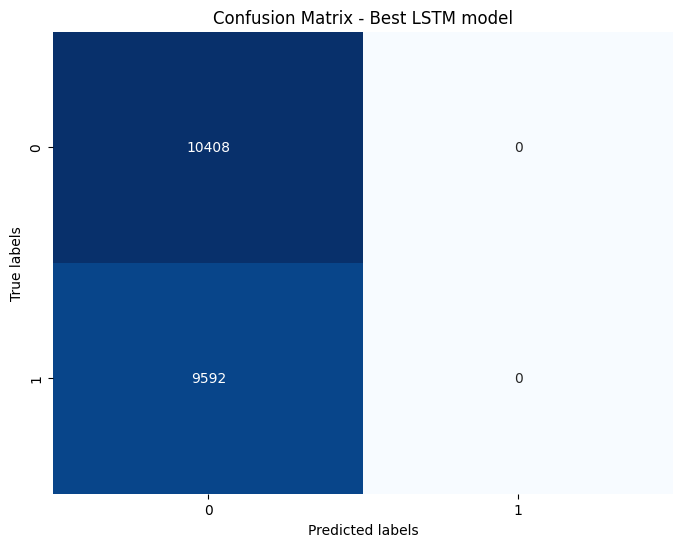

In [ ]:
# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Best LSTM model')
plt.show()


We can see that the percentage that the model thinks it is a 1 label was never above 50%.
The model didn't converge, the % was always just a bit below 50%. So we can say that these are random results

### Best model error analysis

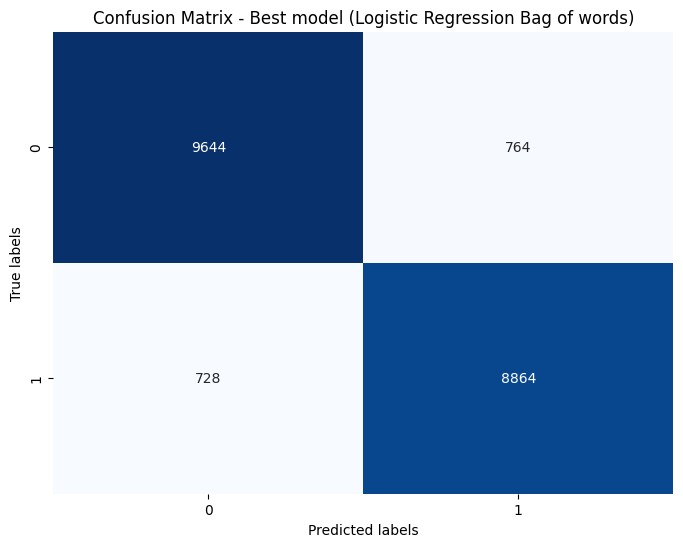

In [ ]:
conf_matrix = confusion_matrix(y_test, y_lr_bow_pred_test)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Best model (Logistic Regression Bag of words)')
plt.show()


In this confusion matrix we see that the False positives and False negatives are just a small percentage of the predictions. We will see now some reviews where the model made a mistake and try to understand why.

In [ ]:
# Print samples where predicted label is not the same as true label

print("Samples where predicted label is not the same as true label:")
pd.set_option('display.max_colwidth', None)

counter=0
for i in range(len(y_lr_bow_pred_test)):
    if y_lr_bow_pred_test[i] != y_test.iloc[i]:
        counter = counter+1
        if counter > 5:
          break
        print(f"\n Index {i}:")
        print(f"Predicted Label:{y_lr_bow_pred_test[i]}")
        print(f"True Label: {y_test.iloc[i]}")
        print(f"Original Review:")
        print(test_data['review'].iloc[i])
        print("Cleaned review:")
        print(test_data['cleaned_review'].iloc[i])
        print()
# 0 negatif
# 1 positif


Samples where predicted label is not the same as true label:

 Index 22:
Predicted Label:0
True Label: 1
Original Review:
Alors oui on est loin du "Parrain" très loin de "Apocalypse Now" mais on le regarde en partie parce que c'est Coppola à la réalisation. Sans s'attendre à un chef d'oeuvre, on en reste pas moins conquit par ce film. L’esthétique de Poe (Notamment sa nouvelle "la Maison Usher") mêlé à la mélancolie Baudelerienne nous fait oublié le pas pataud et hésitant de Val Kilmer miné par quelques kilos en trop ( Bien que sont jeu d'acteur reste tout a fait correct). Coppola revient à une atmosphère plus gothique comme l'était sa vision très personnel du Dracula de Bram Stoker, non s'en emprunté des prises de vues qui rappellerait Burton ou même Lars Von Trier. Sans prendre de risque dans le scénario qui laisse une grande interprétation au spectateur, Coppola change une nouvelle fois de route après les très étrange "L'Homme sans Age" et "Tetro". Bref sa fonctionne et ce film est 

It is even for a human hard to determine if they are positive or negative.   

> C est drôle, follement drôle car les personnages sont encore plus pathétiques que dans le premier épisode. Jean Claude Dus accumule les déceptions sentimentales, Bernard et Nathalie sont odieux en petits bourgeois, Popeye en dragueur minable ... Comme le père Noel la plupart des dialogues sont passés dans l un inconscient collectif !

This review has words like pathetique, deception and minable in there, which can be interpreted as negative, if you don't put the "follement drôle car" into context.


# Conclusion

The best models are the Linear Regression and the Random Forest Classifier but specifically on the embeddings TFIDF and BoW.  
We could have tested another approach on the word2vec, here we sum the words, and also words that are not in the french model are not taken into consideration.  

As the calculation power was not sufficient, there are some tests we wish we would have executed that we couldn't do:
* we tested the LSTM and bi-LSTM only on Word2Vec and not on BoW or TFIDF
* We didn't test LSTM with more or less layers or different amount of features.